In [3]:
#Importing initial libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

#models
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split as tts


Data Preproccesing and Collection

In [4]:
#Read in file
titanic_df = pd.read_csv('Titanic-Dataset.csv')


In [5]:
#Check Number of Rows and Columns
titanic_df.shape

(891, 12)

In [6]:
#Count Categorical Values for Label Encoding later on
cat_count = 0
for dtype in titanic_df.dtypes:
    if dtype == 'object':
        cat_count += 1
print('There are {} categorical columns'.format(cat_count))
print('There are {} numerical columns'.format(len(titanic_df.columns) - cat_count - 1))
#Subtract 1 for ID column

There are 5 categorical columns
There are 6 numerical columns


In [7]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
#look at missing values
total = titanic_df.isnull().sum().sort_values(ascending=False)
percent = (titanic_df.isnull().sum()/titanic_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(20)


,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


Cabing has a lot of missing data, will drop this column. I have pclass which is a better indicator of wealth disparity. It would have been interesting to correlate cabin room position to survival rate. The amount of missing age data is interesting as well. Im not sure if imputing is worth it.

In [9]:
#Handle Missing Values
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)
titanic_df.drop(['Cabin'], axis=1, inplace=True)
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True) #Going to impute mean age for now, curious to test this


In [10]:
total = titanic_df.isnull().sum().sort_values(ascending=False)
percent = (titanic_df.isnull().sum()/titanic_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0


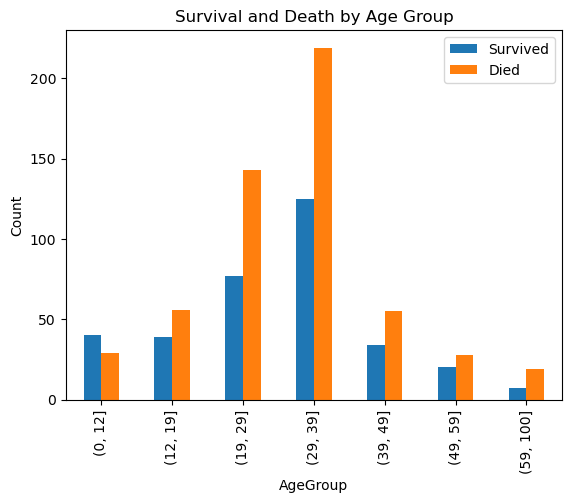

In [13]:
# defining age groups to visualize survival rates
bins = [0, 12, 19, 29, 39, 49, 59, 100]
titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins)

# Group by 'AgeGroup' and sum 'Survived'
grouped = titanic_df.groupby('AgeGroup')['Survived'].sum()

# Calculate the number of deaths per age group
def count_zeros(x):
    counts = x.value_counts()
    return counts.get(0, 0)

deaths = titanic_df.groupby('AgeGroup')['Survived'].apply(count_zeros)

# dataframe for easier visualization
data = pd.DataFrame({'Survived': grouped, 'Died': deaths})

# plot
data.plot(kind='bar', stacked=False)
plt.ylabel('Count')
plt.title('Survival and Death by Age Group')
plt.show()

Model Training

Model Evaluation and Visualation